# U-Net from scratch for segmentation

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

In [2]:
CAMVID_CLASSES = [
    "Sky",
    "Building",
    "Pole",
    "Road",
    "Pavement",
    "Tree",
    "SignSymbol",
    "Fence",
    "Car",
    "Pedestrian",
    "Bicyclist"
]
NUM_CLASSES = len(CAMVID_CLASSES)

NUM_CLASSES

11

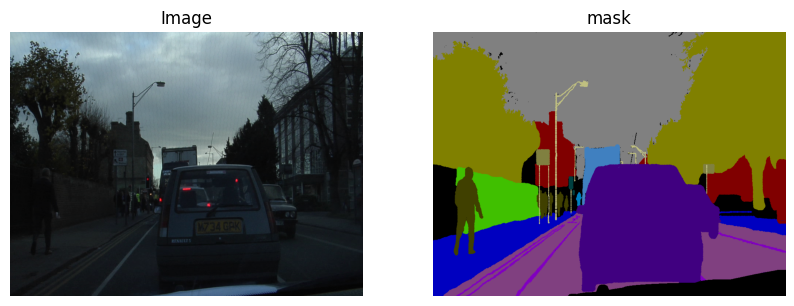

In [3]:
init_dir = os.path.join('./data/CamVid/train/')
file_names = sorted(os.listdir(os.path.join(init_dir, 'images/')))

im = img.imread(os.path.join(init_dir + 'images/', file_names[0]))
mask = img.imread(os.path.join(init_dir + 'masks/', file_names[0].replace('.png', '_L.png')))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(im)
plt.title("Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mask)
plt.title("mask")
plt.axis('off')
plt.show()

In [4]:
from data.camvid_dataset import CamVidDataset
from torch.utils.data import DataLoader

train_loader = DataLoader(CamVidDataset('train'), batch_size=8, shuffle=True)
val_loader = DataLoader(CamVidDataset('val'), batch_size=8, shuffle=False)
test_loader = DataLoader(CamVidDataset('test'), batch_size=8, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5332649..1.82].


Image batch shape:  torch.Size([8, 3, 256, 256])
Mask batch shape:  torch.Size([8, 256, 256])


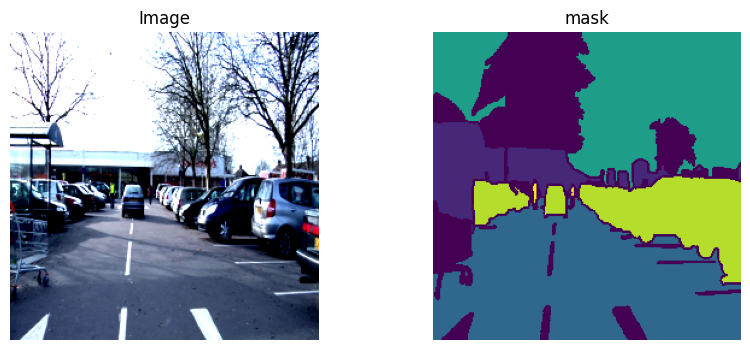

[0 1 3 5 8 9]


In [5]:
for imgs, masks in train_loader:
    print("Image batch shape: ", imgs.size())
    print("Mask batch shape: ", masks.size())
    im = imgs[0].permute(1,2,0) * 0.5 + 0.5  # unnormalize
    mask = masks[0]
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(im)
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.title("mask")
    plt.axis('off')
    plt.show()

    print(np.unique(mask.cpu().numpy()))
    break

In [6]:
from unet.unet import UNet
from torchinfo import summary

model = UNet(in_channels=3, out_channels=NUM_CLASSES)
summary(model, input_size=(8, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [8, 11, 256, 256]         --
├─Encoder: 1-1                           [8, 64, 256, 256]         --
│    └─DoubleConv: 2-1                   [8, 64, 256, 256]         --
│    │    └─Sequential: 3-1              [8, 64, 256, 256]         38,720
│    └─MaxPool2d: 2-2                    [8, 64, 128, 128]         --
├─Encoder: 1-2                           [8, 128, 128, 128]        --
│    └─DoubleConv: 2-3                   [8, 128, 128, 128]        --
│    │    └─Sequential: 3-2              [8, 128, 128, 128]        221,440
│    └─MaxPool2d: 2-4                    [8, 128, 64, 64]          --
├─Encoder: 1-3                           [8, 256, 64, 64]          --
│    └─DoubleConv: 2-5                   [8, 256, 64, 64]          --
│    │    └─Sequential: 3-3              [8, 256, 64, 64]          885,248
│    └─MaxPool2d: 2-6                    [8, 256, 32, 32]          --
├

In [ ]:
from unet.methods import training, evaluating, prediction

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, train_accuracies, val_losses, val_accuracies = training(model, train_loader, criterion, optimizer, device, epochs, val_loader=val_loader)
torch.save(model.state_dict(), './unet_camvid.pth')

Training Progress: 100%|██████████| 20/20 [15:45<00:00, 47.30s/it, train_loss=0.495, val_loss=0.5]  


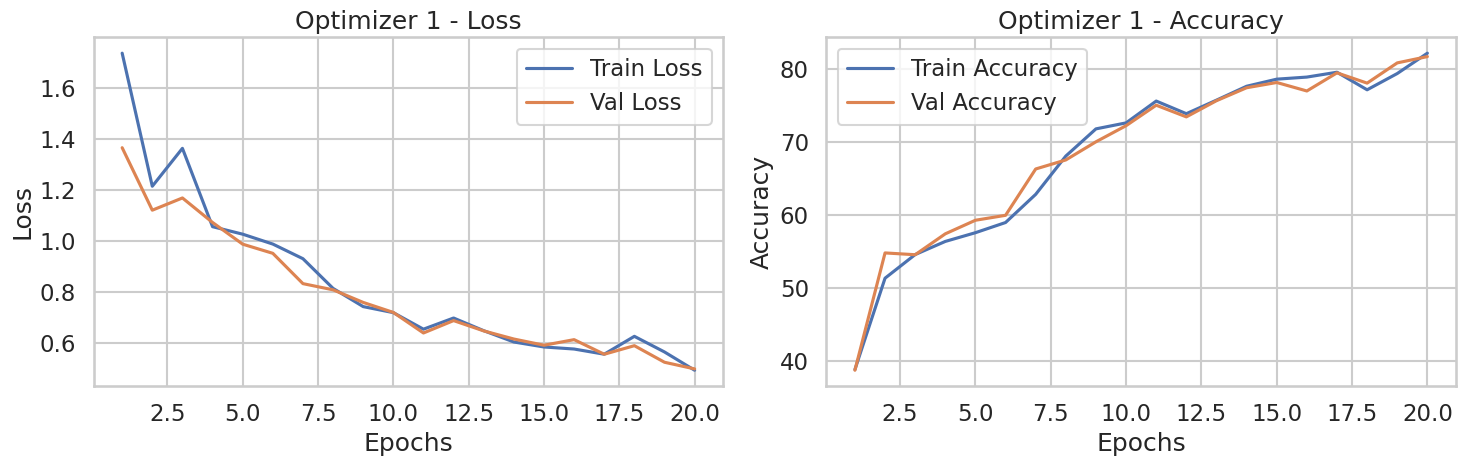

In [ ]:
from utils import plot_metrics

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs=epochs)